(666, 499, 3)

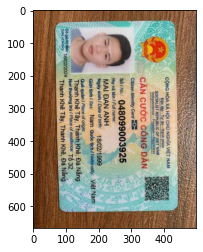

In [47]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from ultralytics import YOLO

def read_img_as_array(img_path):
    image = Image.open(img_path)
    return np.asarray(image)

image = read_img_as_array('C:/Users/Admin/Desktop/A.N lab/test_imgs-raw/cccd2.jpg')

plt.imshow(image)
image.shape

# Alignment
- 4 corners detect by YOLOv8 
- Perspective transform with OpenCV

### Helper function
- Get boxes, classes from raw output
- Process raw 2: encapsulate into a dictionary
- alignment (OpenCV perspective transform)

In [2]:
# Process raw 1: Get boxes, classes from raw output
def _corners_detection_inference(model, img_path):
    results = model.predict(source=img_path, conf=0.5)
    detection_boxes = np.array(results[0].boxes.xyxy)
    detection_classes = np.array(results[0].boxes.cls)

    return detection_boxes, detection_classes

# Process raw 2: encapsulate into a dictionary
def _get_coordinate_dict(image, detection_boxes, detection_classes, category_index):

    
    # eliminate outliers (if exist)
    coordinate_dict = dict()
    height, width, _ = image.shape

    for i in range(len(detection_classes)):
        label = str(category_index[detection_classes[i]])
        real_xmin = int(max(1, detection_boxes[i][0]))
        real_ymin = int(max(1, detection_boxes[i][1]))
        real_xmax = int(min(width, detection_boxes[i][2]))
        real_ymax = int(min(height, detection_boxes[i][3]))
        coordinate_dict[label] = (real_xmin, real_ymin, real_xmax, real_ymax)

    coordinate_dict = {
    key.replace('topleft', 'top_left').replace('topright', 'top_right').replace('botleft', 'bottom_left').replace('botright', 'bottom_right'): value for key, value in coordinate_dict.items()}

    return coordinate_dict

# ALIGNMENT
def _get_center_point(coordinate_dict):
    di = dict()

    for key in coordinate_dict.keys():
        xmin, ymin, xmax, ymax = coordinate_dict[key]
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        di[key] = (x_center, y_center)

    return di


def _find_miss_corner(coordinate_dict):
    position_name = ['top_left', 'top_right', 'bottom_left', 'bottom_right']
    position_index = np.array([0, 0, 0, 0])

    for name in coordinate_dict.keys():
        if name in position_name:
            position_index[position_name.index(name)] = 1

    index = np.argmin(position_index)

    return position_name[index]


def _calculate_missed_coord_corner(coordinate_dict):
    thresh = 0

    index = _find_miss_corner(coordinate_dict)

    # calculate missed corner coordinate
    # case 1: missed corner is "top_left"
    if index == 'top_left':
        midpoint = np.add(coordinate_dict['top_right'], coordinate_dict['bottom_left']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_right'][0] - thresh
        coordinate_dict['top_left'] = (x, y)
    elif index == 'top_right':  # "top_right"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['bottom_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['bottom_left'][0] - thresh
        coordinate_dict['top_right'] = (x, y)
    elif index == 'bottom_left':  # "bottom_left"
        midpoint = np.add(coordinate_dict['top_left'], coordinate_dict['bottom_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_right'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_right'][0] - thresh
        coordinate_dict['bottom_left'] = (x, y)
    elif index == 'bottom_right':  # "bottom_right"
        midpoint = np.add(coordinate_dict['bottom_left'], coordinate_dict['top_right']) / 2
        y = 2 * midpoint[1] - coordinate_dict['top_left'][1] - thresh
        x = 2 * midpoint[0] - coordinate_dict['top_left'][0] - thresh
        coordinate_dict['bottom_right'] = (x, y)

    return coordinate_dict


def _perspective_transform(image, source_points):
    dest_points = np.float32([[0, 0], [1000, 0], [1000, 600], [0, 600]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (1000, 600))
    # dst = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))

    return dst


def align_image(image, coordinate_dict):
    """
    Args: image, coordinates dictionary
    Return: transformed img by
    - Perspective transforming from 4 corners 
    (including cropping via output size of OpenCV func)
    """
    # Interpolate if just have 3 points
    if len(coordinate_dict) < 3:
        # raise ValueError('Image may be right angle! or Please try again')
        print('Image may be right angle! or Please try again')
        return image, False

    # convert (xmin, ymin, xmax, ymax) to (x_center, y_center)
    coordinate_dict = _get_center_point(coordinate_dict)

    if len(coordinate_dict) == 3:
        coordinate_dict = _calculate_missed_coord_corner(coordinate_dict)

    top_left_point = coordinate_dict['top_left']
    top_right_point = coordinate_dict['top_right']
    bottom_right_point = coordinate_dict['bottom_right']
    bottom_left_point = coordinate_dict['bottom_left']

    source_points = np.float32([top_left_point, top_right_point, bottom_right_point, bottom_left_point])

    # align and crop image
    crop = _perspective_transform(image, source_points)

    return crop, True


### Inference

In [3]:
# LOAD MODEL
from ultralytics import YOLO

model = YOLO('C:/Users/Admin/Desktop/A.N lab/KIE/weights/YOLOv8n_4corners_v1.pt')  # pretrained YOLOv8n model

# ALIGNMENT (perspective transform with 4 corners)
def align_based_corners_detect(model, img_path):
    ''' Alignment (rotate and crop) based 4 corners output by Corner detector
    Args: 
        - Model: instance of Corner detector
        - image path: path to local image
    Return:
        - aligned img
    
    '''
    img = read_img_as_array(img_path)

    # detect 4 corners (coordinates)
    detection_boxes, detection_classes = _corners_detection_inference(model, img_path)
    category_index = model.model.names

    # process output -> encapsulate into a dictionary
    coordinate_dict = _get_coordinate_dict(img, detection_boxes, detection_classes, category_index)
    
    # Aligning transformation
    aligned_img, done = align_image(img, coordinate_dict)

    return aligned_img, done

img_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-raw/cccd2.jpg'
image = read_img_as_array(img_path) # read img
aligned_img, done = align_based_corners_detect(model, img_path) # alignment


image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-raw\cccd2.jpg: 640x480 1 botright, 1 topleft, 1 topright, 313.3ms
Speed: 8.1ms preprocess, 313.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


### Draw corners func

VISUALIZATION: Original vs cropped plot

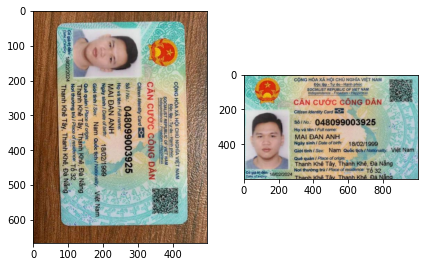

In [4]:
# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

# Display images in subplots
ax1.imshow(image)
ax2.imshow(aligned_img)

# Adjust layout (optional)
plt.tight_layout()

# Show the plot
plt.show()

Draw corners

image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-raw\cccd2.jpg: 640x480 1 botright, 1 topleft, 1 topright, 592.8ms
Speed: 73.0ms preprocess, 592.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 480)
 
 Coordinates dictionary 
 : {'bottom_right': (70, 584, 109, 625), 'top_right': (412, 575, 456, 622), 'top_left': (412, 26, 440, 65)}


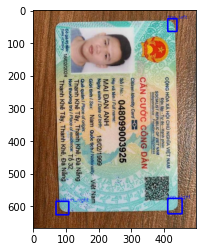

In [7]:
# Output of corner detector
detection_boxes, detection_classes = _corners_detection_inference(model, img_path)
category_index = model.model.names
coordinate_dict = _get_coordinate_dict(image, detection_boxes, detection_classes, category_index)
print(f' \n Coordinates dictionary \n : {coordinate_dict}')

def draw_text_detected(cropped_img, coordinate_dict):
    cr_img = np.copy(cropped_img)
    for name, box in coordinate_dict.items():
        start_point = (box[0], box[1])
        end_point = (box[2], box[3])
        color = (0, 0, 255)
        img = cv2.rectangle(cr_img, start_point, end_point, color, 3) 

        # Draw label
        label = str(name)
        cv2.putText(cr_img, label, (start_point[0], start_point[1]), cv2.FONT_HERSHEY_SIMPLEX, color=(0, 0, 255),
            fontScale=0.5)
        
    return cr_img

# align image
corner_detected_img = draw_text_detected(image, coordinate_dict)
plt.imshow(corner_detected_img)

# Text detection
```yaml
args:
    aligned img ( model input size (640, 640))
return:
    text detected boxes: id boxes, name boxes and birth boxes
```


## Helper function
- preprocess image by resize_fit_black_edge (without distortion)
- NMS (optional): implicitly perform in YOLO algorithm
- Sort boxes as top to bottom, left to right
    - Args: detection_boxes, detection_classes
    - Return: id_boxes, name_boxes and birth_boxes

In [23]:
"""resize and fit in black edge (without distortion)"""
def _resize_fit_black_edge(image, target_size=(640, 640)):
    # Get the original image dimensions
    original_height, original_width, _ = image.shape

    # Calculate the scaling factors for width and height
    width_scale = target_size[0] / original_width
    height_scale = target_size[1] / original_height

    # Determine the scaling factor to fit the image within the target size
    scale_factor = min(width_scale, height_scale)

    # Resize the image while maintaining the aspect ratio
    resized_image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    # Create a black canvas of the target size
    canvas = np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

    # Calculate the position to paste the resized image
    x_offset = (target_size[0] - resized_image.shape[1]) // 2
    y_offset = (target_size[1] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[y_offset:y_offset + resized_image.shape[0], x_offset:x_offset + resized_image.shape[1]] = resized_image

    return canvas

"""NMS (Non maximum suppression) eliminate redundant boxes"""
def _non_max_suppression_fast(boxes, labels, overlapThresh):
    """ filters object detector predictions / removes duplicates

    Args:
        boxes: 
        labels:
        overlap threshold: 
    Returns:
        the bounding boxes that were picked using the integer data type
    """
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return [None, None]

    # if the bounding boxes are integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    #
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 1]
    y1 = boxes[:, 0]
    x2 = boxes[:, 3]
    y2 = boxes[:, 2]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    final_labels = [labels[idx] for idx in pick]
    final_labels = np.array(final_labels).astype("int")

    final_boxes = boxes[pick].astype("int")
    return final_boxes, final_labels

"""encapsulate in one dictionary"""
def _get_text_coordinate_dict(image, detection_boxes, detection_classes, category_index):
    """
    Args: image, detection_boxes, detection_classes, category_index
    Return: Dictionary
    - detected label: boxes
    ...
    - category_index: category_index
    """
    # eliminate outliers (if exist)
    coordinate_dict = dict()
    for label in category_index.values():
        coordinate_dict[label] = []
    height, width, _ = image.shape

    for idx, i in enumerate(detection_classes):
        label = category_index[i]
        real_xmin = int(max(1, detection_boxes[idx][0]))
        real_ymin = int(max(1, detection_boxes[idx][1]))
        real_xmax = int(min(width, detection_boxes[idx][2]))
        real_ymax = int(min(height, detection_boxes[idx][3]))

        coordinate_dict[label].append((real_xmin, real_ymin, real_xmax, real_ymax))

    coordinate_dict = {
        key.replace('topleft', 'top_left').replace('topright', 'top_right').replace('botleft', 'bottom_left').replace('botright', 'bottom_right'): value for key, value in coordinate_dict.items()
    }

    coordinate_dict['category_index'] = category_index

    return coordinate_dict

"""Process raw output"""
def _text_detection_inference(model, img):
    results = model.predict(img, conf=0.5)
    detection_boxes = np.array(results[0].boxes.xyxy)
    detection_classes = np.array(results[0].boxes.cls)

    return detection_boxes, detection_classes

"""Sort boxes"""
# print(f'Catefory index {text_detection_model.model.names}')
def _get_y1(x):
    return x[1]


def _get_x1(x):
    return x[0]


def _sort_each_category(category_text_boxes):
    """
    Args: boxes
    Return:
    - Right order boxes corresponding to indexes: top to bottom, left to right 
    """
    try:
        min_y1 = min(category_text_boxes, key=_get_y1)[0]
    except:
        return None

    mask = np.where(category_text_boxes[:, 0] < min_y1 + 10, True, False)
    line1_text_boxes = category_text_boxes[mask]
    line2_text_boxes = category_text_boxes[np.invert(mask)]

    line1_text_boxes = sorted(line1_text_boxes, key=_get_x1)
    line2_text_boxes = sorted(line2_text_boxes, key=_get_x1)

    if len(line2_text_boxes) != 0:
        merged_text_boxes = [*line1_text_boxes, *line2_text_boxes]
    else:
        merged_text_boxes = line1_text_boxes

    return merged_text_boxes

def sort_text(detection_boxes, detection_labels):
    """Sort box in name_boxes as right order, i.e vu quy ngox > vu ngoc quy (as reader 
    view/order from top to bottom, left to right)

    Args:
    - detection boxes
    - detection labels
    Return:
    - arranged id_boxes, name_boxes, birth_boxes according to its coordinate

    """
    
    #  Get boxes correspond to its label 
    detection_labels = np.array(detection_labels)
    birth_boxes = detection_boxes[detection_labels == 0]
    id_boxes = detection_boxes[detection_labels == 1]
    name_boxes = detection_boxes[detection_labels == 2]

    # arrange boxes
    id_boxes = _sort_each_category(id_boxes)
    name_boxes = _sort_each_category(name_boxes)
    birth_boxes = _sort_each_category(birth_boxes)

    return id_boxes, name_boxes, birth_boxes

(640, 640, 3)

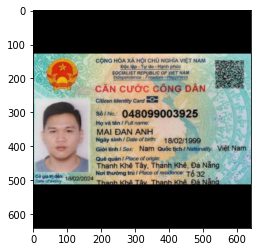

In [12]:
# model input size (640, 640)
# so preprocess image by resize_fit_black_edge (without distortion)
aligned_img = _resize_fit_black_edge(aligned_img)

plt.imshow(aligned_img)
aligned_img.shape

### Draw text detected bounding boxes


image 1/1 C:\Users\Admin\Desktop\A.N lab\test_imgs-after_alighment\img1.jpg: 384x640 1 birthday, 1 id, 3 names, 286.9ms
Speed: 8.1ms preprocess, 286.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)


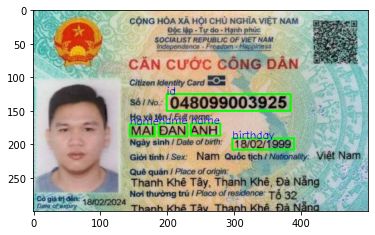

In [5]:
def draw_text_detected(img_path, model):
    ''' Draw 4 corners output by Corner detector
    Args: 
        - Model: instance of Corner detector
        - 
    Return:
        - Annotated img
    
    '''
    img = read_img_as_array(img_path)

    # Output of text detector
    detection_boxes, detection_classes = _text_detection_inference(model, img_path)
    category_index = model.model.names
    
    # preprocessing output -> encapsulate into a dictionary
    coordinate_dict = _get_text_coordinate_dict(img, detection_boxes, detection_classes, category_index)
    del coordinate_dict['category_index']
    cr_img = np.copy(img)
    for name, boxes in coordinate_dict.items():
        for box in boxes:
            start_point = (box[0], box[1])
            end_point = (box[2], box[3])
            color = (0, 255, 0)
            # Draw bounding box
            img = cv2.rectangle(cr_img, start_point, end_point, color, 2) 

            # Draw label
            label = str(name)
            cv2.putText(cr_img, label, (start_point[0], start_point[1]), cv2.FONT_HERSHEY_SIMPLEX, color=(0, 0, 255),
                fontScale=0.5)
        
    return cr_img

img_path = 'C:/Users/Admin/Desktop/A.N lab/test_imgs-after_alighment/img1.jpg'
# Draw bounding boxes of Corner detector
text_detected_img = draw_text_detected(img_path, text_detection_model)
plt.imshow(text_detected_img)

## Inference

In [19]:
# LOAD text detection model
text_detection_model = YOLO('C:/Users/Admin/Desktop/A.N lab/KIE/weights/YOLOv8-text_detection-v3.pt')

In [25]:
# process raw output
detection_boxes, detection_classes = _text_detection_inference(text_detection_model, aligned_img)
# NMS
detection_boxes, detection_classes = _non_max_suppression_fast(boxes=detection_boxes,
                                                                        labels=detection_classes,
                                                                        overlapThresh=0.15)
# sort text boxes according to coordinate: top -> bottom, left -> right
id_boxes, name_boxes, birth_boxes = sort_text(detection_boxes, detection_classes)

print(
    f'After sorting function:'
    f'\n id \n {id_boxes}',
    f'\n name \n {name_boxes}',
    f'\n birth \n {birth_boxes}',
)

0: 640x640 1 birthday, 1 id, 3 names, 681.3ms
Speed: 82.8ms preprocess, 681.3ms inference, 40.3ms postprocess per image at shape (1, 3, 640, 640)
After sorting function:
 id 
 [array([255, 290, 490, 320])] 
 name 
 [array([184, 345, 232, 369]), array([238, 345, 294, 368]), array([300, 345, 358, 368])] 
 birth 
 [array([382, 372, 497, 395])]


# Text regconition
- args:
    - aligned image
    - id boxes
    - name boxes
    - birth boxes
- return 
    - required extracted information

## Load model
- id: YOLOv8
- name: VietOCR
- birtth: YOLOv8 

### VietOCR init

In [52]:
import math

import torch
from torch import nn
from torchvision import models
from collections import defaultdict


### CNN (VGG)
class Vgg(nn.Module):
    def __init__(self, name, ss, ks, hidden, pretrained=True, dropout=0.5):
        super(Vgg, self).__init__()
        cnn = models.vgg19_bn(pretrained=pretrained)

        pool_idx = 0
        
        for i, layer in enumerate(cnn.features):
            if isinstance(layer, torch.nn.MaxPool2d):        
                cnn.features[i] = torch.nn.AvgPool2d(kernel_size=ks[pool_idx], stride=ss[pool_idx], padding=0)
                pool_idx += 1
 
        self.features = cnn.features
        self.dropout = nn.Dropout(dropout)
        self.last_conv_1x1 = nn.Conv2d(512, hidden, 1)

    def forward(self, x):
        """
        Shape: 
            - x: (N, C, H, W)
            - output: (W, N, C)
        """

        conv = self.features(x)
        conv = self.dropout(conv)
        conv = self.last_conv_1x1(conv)

        conv = conv.transpose(-1, -2)
        conv = conv.flatten(2)
        conv = conv.permute(-1, 0, 1)
        return conv


def vgg19_bn(ss, ks, hidden, pretrained=True, dropout=0.5):
    return Vgg('vgg19_bn', ss, ks, hidden, pretrained, dropout)

class CNN(nn.Module):
    def __init__(self, backbone, **kwargs):
        super(CNN, self).__init__()
        self.model = vgg19_bn(**kwargs)

    def forward(self, x):
        return self.model(x)

    def freeze(self):
        for name, param in self.model.features.named_parameters():
            if name != 'last_conv_1x1':
                param.requires_grad = False

    def unfreeze(self):
        for param in self.model.features.parameters():
            param.requires_grad = True


### LANGUAGE TRANSFORMER
class LanguageTransformer(nn.Module):
    def __init__(self, vocab_size, 
                    d_model, nhead, 
                    num_encoder_layers, num_decoder_layers, 
                    dim_feedforward, max_seq_length, 
                    pos_dropout, trans_dropout):
        super().__init__()
        
        self.d_model = d_model
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, 
                                            num_encoder_layers, num_decoder_layers, 
                                            dim_feedforward, trans_dropout)
        
        self.fc = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        Shape:
            - src: (W, N, C)
            - tgt: (T, N) 
            - src_key_padding_mask: (N, S)
            - tgt_key_padding_mask: (N, T)
            - memory_key_padding_mask: (N, S)
            - output: (N, T, E)
            
        """
        tgt_mask = self.gen_nopeek_mask(tgt.shape[0]).to(src.device)
        
        src = self.pos_enc(src*math.sqrt(self.d_model))

        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        
        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                    tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = output.transpose(0, 1)
        return self.fc(output)

    def gen_nopeek_mask(self, length):
        mask = (torch.triu(torch.ones(length, length)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

        return mask
    
    def forward_encoder(self, src):
        src = self.pos_enc(src*math.sqrt(self.d_model))
        memory = self.transformer.encoder(src)
        return memory
    
    def forward_decoder(self, tgt, memory):
        tgt_mask = self.gen_nopeek_mask(tgt.shape[0]).to(tgt.device)
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        
        output = self.transformer.decoder(tgt, memory, tgt_mask=tgt_mask)
        output = output.transpose(0, 1)

        return self.fc(output), memory
    
    def expand_memory(self, memory, beam_size):
        memory = memory.repeat(1, beam_size, 1)
        return memory
    
    def get_memory(self, memory, i):
        memory = memory[:, [i], :]
        return memory

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x)

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(LearnedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.pos_embed = nn.Embedding(max_len, d_model)
        self.layernorm = LayerNorm(d_model)

    def forward(self, x):
        seq_len = x.size(0)
        pos = torch.arange(seq_len, dtype=torch.long, device=x.device)
        pos = pos.unsqueeze(-1).expand(x.size()[:2])
        x = x + self.pos_embed(pos)
        return self.dropout(self.layernorm(x))

class LayerNorm(nn.Module):
    "A layernorm module in the TF style (epsilon inside the square root)."
    def __init__(self, d_model, variance_epsilon=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta  = nn.Parameter(torch.zeros(d_model))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta  
    

### VIET-OCR
class VietOCR(nn.Module):
    def __init__(self, vocab_size,
                    backbone,
                    cnn_args, 
                    transformer_args, seq_modeling='transformer'):
        
        super(VietOCR, self).__init__()
        
        self.cnn = CNN(backbone, **cnn_args)
        self.transformer = LanguageTransformer(vocab_size, **transformer_args)

    def forward(self, img, tgt_input, tgt_key_padding_mask):
        """
        Shape:
            - img: (N, C, H, W)
            - tgt_input: (T, N)
            - tgt_key_padding_mask: (N, T)
            - output: b t v
        """
        src = self.cnn(img)
        outputs = self.transformer(src, tgt_input, tgt_key_padding_mask=tgt_key_padding_mask)
        return outputs


#### Vocal

class Vocab():
    def __init__(self, chars):
        self.pad = 0
        self.go = 1
        self.eos = 2
        self.mask_token = 3

        self.chars = chars

        self.c2i = {c:i+4 for i, c in enumerate(chars)}

        self.i2c = {i+4:c for i, c in enumerate(chars)}
        
        self.i2c[0] = '<pad>'
        self.i2c[1] = '<sos>'
        self.i2c[2] = '<eos>'
        self.i2c[3] = '*'

    def encode(self, chars):
        return [self.go] + [self.c2i[c] for c in chars] + [self.eos]
    
    def decode(self, ids):
        first = 1 if self.go in ids else 0
        last = ids.index(self.eos) if self.eos in ids else None
        sent = ''.join([self.i2c[i] for i in ids[first:last]])
        return sent
    
    def __len__(self):
        return len(self.c2i) + 4
    
    def batch_decode(self, arr):
        texts = [self.decode(ids) for ids in arr]
        return texts

    def __str__(self):
        return self.chars

#### Translate and build model function

def translate(img, model, max_seq_length=128, sos_token=1, eos_token=2):
    """data: BxCXHxW"""
    model.eval()
    device = img.device

    with torch.no_grad():
        src = model.cnn(img)
        memory = model.transformer.forward_encoder(src)

        translated_sentence = [[sos_token] * len(img)]
        max_length = 0

        while max_length <= max_seq_length and not all(np.any(np.asarray(translated_sentence).T == eos_token, axis=1)):
            tgt_inp = torch.LongTensor(translated_sentence).to(device)
            output, memory = model.transformer.forward_decoder(tgt_inp, memory)
            output = output.to('cpu')

            _, indices = torch.topk(output, 5)

            indices = indices[:, -1, 0]
            indices = indices.tolist()

            translated_sentence.append(indices)
            max_length += 1

            del output

        translated_sentence = np.asarray(translated_sentence).T

    return translated_sentence


def build_model(config):
    vocab = Vocab(config['vocab'])
    device = config['device']
    
    model = VietOCR(len(vocab),
            config['backbone'],
            config['cnn'], 
            config['transformer'],
            config['seq_modeling'])
    
    model = model.to(device)

    return model, vocab

### Predictor class
class Predictor(object):
    def __init__(self, config):
        device = config['device']

        model, vocab = build_model(config)
        weights = config['weights']

        model.load_state_dict(torch.load(weights, map_location=torch.device(device)))

        self.config = config
        self.model = model
        self.vocab = vocab

    def predict(self, img):
        img = self.preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        img = torch.FloatTensor(img)
        img = img.to(self.config['device'])
        s = translate(img, self.model)[0].tolist()

        s = self.vocab.decode(s)

        return s

    def batch_predict(self, images):
        """
        param: images : list of ndarray
        """
        batch_dict, indices = self.batch_process(images)
        list_keys = [i for i in batch_dict if batch_dict[i] != batch_dict.default_factory()]
        result = list([])

        for width in list_keys:
            batch = batch_dict[width]
            batch = np.asarray(batch)
            batch = torch.FloatTensor(batch)
            batch = batch.to(self.config['device'])
            sent = translate(batch, self.model).tolist()

            batch_text = self.vocab.batch_decode(sent)
            result.extend(batch_text)

        # sort text result to original coordinate
        z = zip(result, indices)
        sorted_result = sorted(z, key=lambda element: element[1])
        result, _ = zip(*sorted_result)

        return result

    def preprocess_input(self, image):
        """
        param: image: ndarray of image
        """
        h, w, _ = image.shape
        new_w, image_height = self.resize_v1(w, h, self.config['dataset']['image_height'],
                                                self.config['dataset']['image_min_width'],
                                                self.config['dataset']['image_max_width'])

        img = cv2.resize(image, (new_w, image_height))
        img = np.transpose(img, (2, 0, 1))
        img = img / 255.0

        return img

    def batch_process(self, images):
        batch_img_dict = defaultdict(list)
        image_height = self.config['dataset']['image_height']

        batch_img_li = [self.preprocess_input(img) for img in images]
        batch_imgs, width_list, indices = self.sort_width(batch_img_li, reverse=False)

        min_bucket_width = min(width_list)
        max_width = max(width_list)
        thresh = 30
        max_bucket_width = np.minimum(min_bucket_width + thresh, max_width)

        for i, image in enumerate(batch_imgs):
            w = image.shape[2]

            # reset min_bucket_width, max_bucket_width
            if w > max_bucket_width:
                min_bucket_width = w
                max_bucket_width = np.minimum(min_bucket_width + thresh, max_width)

            avg_bucket_width = int((max_bucket_width + min_bucket_width) / 2)

            new_img = self.resize_v2(image, avg_bucket_width, height=image_height)
            batch_img_dict[avg_bucket_width].append(new_img)

        return batch_img_dict, indices

    @staticmethod
    def sort_width(batch_img, reverse=False):
        def get_img_width(element):
            img = element[0]
            c, h, w = img.shape
            return w

        batch = list(zip(batch_img, range(len(batch_img))))
        sorted_batch = sorted(batch, key=get_img_width, reverse=reverse)
        sorted_batch_img, indices = list(zip(*sorted_batch))

        return sorted_batch_img, list(map(get_img_width, batch)), indices

    @staticmethod
    def resize_v1(w, h, expected_height, image_min_width, image_max_width):
        new_w = int(expected_height * float(w) / float(h))
        round_to = 10
        new_w = math.ceil(new_w / round_to) * round_to
        new_w = max(new_w, image_min_width)
        new_w = min(new_w, image_max_width)

        return new_w, expected_height

    @staticmethod
    def resize_v2(img, width, height):
        new_img = np.transpose(img, (1, 2, 0))
        new_img = cv2.resize(new_img, (width, height), cv2.INTER_AREA)
        new_img = np.transpose(new_img, (2, 0, 1))

        return new_img




### VietOCR instance

In [53]:
import yaml

vietocr = {
    'base_config': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/base.yml',
    'vgg_config': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/vgg-transformer.yml',
    'model_weight': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/transformerocr.pth'
}


class TextRecognition(object):
    def __init__(self):
        self.ocr_config = self.load_config()
        self.detector = Predictor(self.ocr_config)

    def load_config(self):
        # load base config
        ocr_config = self.read_from_config(file_yml=vietocr['base_config'])

        # load vgg transformer config
        vgg_config = self.read_from_config(file_yml=vietocr['vgg_config'])

        # update base config
        ocr_config.update(vgg_config)

        # load model from checkpoint
        ocr_config['weights'] = vietocr['model_weight']
        ocr_config['predictor']['beamsearch'] = False

        return ocr_config

    @staticmethod
    def read_from_config(file_yml):
        with open(file_yml, encoding='utf-8') as f:
            config = yaml.safe_load(f)

        return config

    def predict(self, image):
        # image = Image.fromarray(image)
        result = self.detector.predict(image)

        return result

    def predict_on_batch(self, batch_images):
        return self.detector.batch_predict(batch_images)


vietocr_model = TextRecognition()


### YOLOv8 birth

In [62]:
# Load a text regconition model
birth_reg_model_path = 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/reg/yolov8-num_reg-birth-v3.pt'
model_birth_reg = YOLO(birth_reg_model_path)  # pretrained YOLOv8n model
model_birth_reg.model.names[0] = '/' # change 0: '-' to 0: '/ 

## Helper function
- Crop patch
- process raw birth:
    - process raw output from YOLO and then post-processing to get required birth

In [77]:
"""crop corresponding boxes"""
def _text_crop(cropped_img, boxes):
    ''' crop corresponding boxes
    cropped_img: (h, w, c)
    '''
    text_crop = []
    if len(boxes) == 1:
        x_min, y_min, x_max, y_max = boxes[0]
        text_crop.append(cropped_img[y_min:y_max, x_min:x_max])
    else:
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            text_crop.append(cropped_img[y_min:y_max, x_min:x_max])

    return text_crop

def _display_images(images, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(20, 20))
    axs = axs.ravel()
    for i in range(rows * cols):
        axs[i].imshow(images[i])
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

"""prosess output from YOLO, post-processing birth"""
def process_raw_birth(raw_birth):
    ''' Choose top k value: (k=10). Hence, sort boxes as left to right, and then
    id is concatenation of all classes 
    Args: Yolo result object
    Return: birth (dd/mm/yyyy)
    '''
    top_k = 10
    det_boxes = np.array(raw_birth[0].boxes.xyxy[:top_k])
    det_clss = [int(i) for i in np.array(raw_birth[0].boxes.cls[:top_k])]

    # list of tuples: 1st = class, 2nd = corresponding box
    detection_tuples = list(zip(det_clss, det_boxes))

    # Sort the tuples based on the x and y coordinates of the boxes
    detection_tuples.sort(key=lambda x: (x[1][0], x[1][1]))

    # Format result as dd/mm/yyyy
    category = raw_birth[0].names
    birth = ''.join(str(category[t[0]]) for t in detection_tuples)
    return birth

def process_raw_id(raw_id):
    ''' Choose top k value: (k=10 for id). Hence, sort boxes as left to right,
    and then id is concatenation of all classes 
    Args: Yolo result object
    Return: id (str) - 10 char
    '''
    top_k = 12
    det_boxes = np.array(raw_id[0].boxes.xyxy[:top_k])
    det_clss = [int(i) for i in np.array(raw_id[0].boxes.cls[:top_k])]

    # list of tuples: 1st = class, 2nd = corresponding box
    detection_tuples = list(zip(det_clss, det_boxes))

    # Sort the tuples based on the x and y coordinates of the boxes
    detection_tuples.sort(key=lambda x: (x[1][0], x[1][1]))

    # Concatenate the keys
    category = raw_id[0].names
    id_number = ''.join(str(category[t[0]]) for t in detection_tuples)

    # print(id_number)
    return id_number

## Inference

In [36]:
# Get patches 
id_text_crops = _text_crop(aligned_img, id_boxes) # id patches
name_text_crops = _text_crop(aligned_img, name_boxes) # name patches
birth_text_crops = _text_crop(aligned_img, birth_boxes) # name patches

In [79]:
# INFERENCE
# id
raw_id =  model_birth_reg.predict(id_text_crops[0])
id = process_raw_id(raw_id)

# name
raw_name = vietocr_model.predict_on_batch(name_text_crops)
name = ' '.join(raw_name) 

# birth
raw_birth = model_birth_reg.predict(birth_text_crops)
birth = process_raw_birth(raw_birth)

print(
    f'\n id: {id}',
    f'\n name: {name}',
    f'\n birth: {birth}',
)


0: 96x640 4 0s, 1 2, 1 3, 1 4, 1 5, 1 8, 3 9s, 121.5ms
Speed: 0.0ms preprocess, 121.5ms inference, 0.0ms postprocess per image at shape (1, 3, 96, 640)

0: 128x640 2 /s, 1 0, 2 1s, 1 2, 1 8, 3 9s, 110.0ms
Speed: 0.0ms preprocess, 110.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 640)

 id: 048099003925 
 name: mai đan anh 
 birth: 18/02/1999


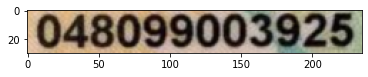

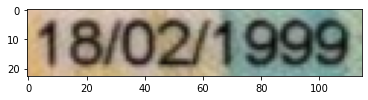

In [46]:
plt.imshow(id_text_crops[0])
plt.show()

plt.imshow(birth_text_crops[0])
plt.show()

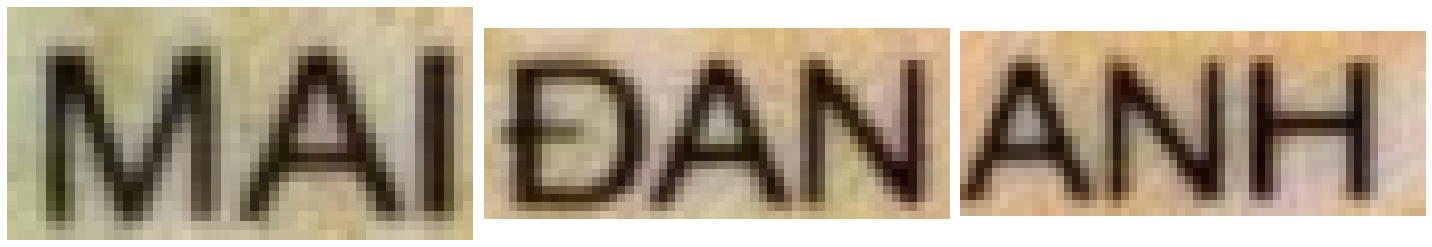

In [49]:
col = 3
num = 3
row = int(num / col)
_display_images(name_text_crops, row, col) # input: patches list, row num, col num

### Name

#### VietOCR

In [50]:
import math

import torch
from torch import nn
from torchvision import models
from collections import defaultdict


### CNN (VGG)
class Vgg(nn.Module):
    def __init__(self, name, ss, ks, hidden, pretrained=True, dropout=0.5):
        super(Vgg, self).__init__()
        cnn = models.vgg19_bn(pretrained=pretrained)

        pool_idx = 0
        
        for i, layer in enumerate(cnn.features):
            if isinstance(layer, torch.nn.MaxPool2d):        
                cnn.features[i] = torch.nn.AvgPool2d(kernel_size=ks[pool_idx], stride=ss[pool_idx], padding=0)
                pool_idx += 1

        self.features = cnn.features
        self.dropout = nn.Dropout(dropout)
        self.last_conv_1x1 = nn.Conv2d(512, hidden, 1)

    def forward(self, x):
        """
        Shape: 
            - x: (N, C, H, W)
            - output: (W, N, C)
        """

        conv = self.features(x)
        conv = self.dropout(conv)
        conv = self.last_conv_1x1(conv)

        conv = conv.transpose(-1, -2)
        conv = conv.flatten(2)
        conv = conv.permute(-1, 0, 1)
        return conv


def vgg19_bn(ss, ks, hidden, pretrained=True, dropout=0.5):
    return Vgg('vgg19_bn', ss, ks, hidden, pretrained, dropout)

class CNN(nn.Module):
    def __init__(self, backbone, **kwargs):
        super(CNN, self).__init__()
        self.model = vgg19_bn(**kwargs)

    def forward(self, x):
        return self.model(x)

    def freeze(self):
        for name, param in self.model.features.named_parameters():
            if name != 'last_conv_1x1':
                param.requires_grad = False

    def unfreeze(self):
        for param in self.model.features.parameters():
            param.requires_grad = True


### LANGUAGE TRANSFORMER
class LanguageTransformer(nn.Module):
    def __init__(self, vocab_size, 
                    d_model, nhead, 
                    num_encoder_layers, num_decoder_layers, 
                    dim_feedforward, max_seq_length, 
                    pos_dropout, trans_dropout):
        super().__init__()
        
        self.d_model = d_model
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, 
                                            num_encoder_layers, num_decoder_layers, 
                                            dim_feedforward, trans_dropout)
        
        self.fc = nn.Linear(d_model, vocab_size)
        
    def forward(self, src, tgt, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        Shape:
            - src: (W, N, C)
            - tgt: (T, N) 
            - src_key_padding_mask: (N, S)
            - tgt_key_padding_mask: (N, T)
            - memory_key_padding_mask: (N, S)
            - output: (N, T, E)
            
        """
        tgt_mask = self.gen_nopeek_mask(tgt.shape[0]).to(src.device)
        
        src = self.pos_enc(src*math.sqrt(self.d_model))

        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        
        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                    tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = output.transpose(0, 1)
        return self.fc(output)

    def gen_nopeek_mask(self, length):
        mask = (torch.triu(torch.ones(length, length)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

        return mask
    
    def forward_encoder(self, src):
        src = self.pos_enc(src*math.sqrt(self.d_model))
        memory = self.transformer.encoder(src)
        return memory
    
    def forward_decoder(self, tgt, memory):
        tgt_mask = self.gen_nopeek_mask(tgt.shape[0]).to(tgt.device)
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        
        output = self.transformer.decoder(tgt, memory, tgt_mask=tgt_mask)
        output = output.transpose(0, 1)

        return self.fc(output), memory
    
    def expand_memory(self, memory, beam_size):
        memory = memory.repeat(1, beam_size, 1)
        return memory
    
    def get_memory(self, memory, i):
        memory = memory[:, [i], :]
        return memory

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]

        return self.dropout(x)

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(LearnedPositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.pos_embed = nn.Embedding(max_len, d_model)
        self.layernorm = LayerNorm(d_model)

    def forward(self, x):
        seq_len = x.size(0)
        pos = torch.arange(seq_len, dtype=torch.long, device=x.device)
        pos = pos.unsqueeze(-1).expand(x.size()[:2])
        x = x + self.pos_embed(pos)
        return self.dropout(self.layernorm(x))

class LayerNorm(nn.Module):
    "A layernorm module in the TF style (epsilon inside the square root)."
    def __init__(self, d_model, variance_epsilon=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta  = nn.Parameter(torch.zeros(d_model))
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta  
    

### VIET-OCR
class VietOCR(nn.Module):
    def __init__(self, vocab_size,
                    backbone,
                    cnn_args, 
                    transformer_args, seq_modeling='transformer'):
        
        super(VietOCR, self).__init__()
        
        self.cnn = CNN(backbone, **cnn_args)
        self.transformer = LanguageTransformer(vocab_size, **transformer_args)

    def forward(self, img, tgt_input, tgt_key_padding_mask):
        """
        Shape:
            - img: (N, C, H, W)
            - tgt_input: (T, N)
            - tgt_key_padding_mask: (N, T)
            - output: b t v
        """
        src = self.cnn(img)
        outputs = self.transformer(src, tgt_input, tgt_key_padding_mask=tgt_key_padding_mask)
        return outputs


#### Vocal
class Vocab():
    def __init__(self, chars):
        self.pad = 0
        self.go = 1
        self.eos = 2
        self.mask_token = 3

        self.chars = chars

        self.c2i = {c:i+4 for i, c in enumerate(chars)}

        self.i2c = {i+4:c for i, c in enumerate(chars)}
        
        self.i2c[0] = '<pad>'
        self.i2c[1] = '<sos>'
        self.i2c[2] = '<eos>'
        self.i2c[3] = '*'

    def encode(self, chars):
        return [self.go] + [self.c2i[c] for c in chars] + [self.eos]
    
    def decode(self, ids):
        first = 1 if self.go in ids else 0
        last = ids.index(self.eos) if self.eos in ids else None
        sent = ''.join([self.i2c[i] for i in ids[first:last]])
        return sent
    
    def __len__(self):
        return len(self.c2i) + 4
    
    def batch_decode(self, arr):
        texts = [self.decode(ids) for ids in arr]
        return texts

    def __str__(self):
        return self.chars

#### Translate and build model function
def translate(img, model, max_seq_length=128, sos_token=1, eos_token=2):
    """data: BxCXHxW"""
    model.eval()
    device = img.device

    with torch.no_grad():
        src = model.cnn(img)
        memory = model.transformer.forward_encoder(src)

        translated_sentence = [[sos_token] * len(img)]
        max_length = 0

        while max_length <= max_seq_length and not all(np.any(np.asarray(translated_sentence).T == eos_token, axis=1)):
            tgt_inp = torch.LongTensor(translated_sentence).to(device)
            output, memory = model.transformer.forward_decoder(tgt_inp, memory)
            output = output.to('cpu')

            _, indices = torch.topk(output, 5)

            indices = indices[:, -1, 0]
            indices = indices.tolist()

            translated_sentence.append(indices)
            max_length += 1

            del output

        translated_sentence = np.asarray(translated_sentence).T

    return translated_sentence


def build_model(config):
    vocab = Vocab(config['vocab'])
    device = config['device']
    
    model = VietOCR(len(vocab),
            config['backbone'],
            config['cnn'], 
            config['transformer'],
            config['seq_modeling'])
    
    model = model.to(device)

    return model, vocab

### Predictor class
class Predictor(object):
    def __init__(self, config):
        device = config['device']

        model, vocab = build_model(config)
        weights = config['weights']

        model.load_state_dict(torch.load(weights, map_location=torch.device(device)))

        self.config = config
        self.model = model
        self.vocab = vocab

    def predict(self, img):
        img = self.preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        img = torch.FloatTensor(img)
        img = img.to(self.config['device'])
        s = translate(img, self.model)[0].tolist()

        s = self.vocab.decode(s)

        return s

    def batch_predict(self, images):
        """
        param: images : list of ndarray
        """
        batch_dict, indices = self.batch_process(images)
        list_keys = [i for i in batch_dict if batch_dict[i] != batch_dict.default_factory()]
        result = list([])

        for width in list_keys:
            batch = batch_dict[width]
            batch = np.asarray(batch)
            batch = torch.FloatTensor(batch)
            batch = batch.to(self.config['device'])
            sent = translate(batch, self.model).tolist()

            batch_text = self.vocab.batch_decode(sent)
            result.extend(batch_text)

        # sort text result to original coordinate
        z = zip(result, indices)
        sorted_result = sorted(z, key=lambda element: element[1])
        result, _ = zip(*sorted_result)

        return result

    def preprocess_input(self, image):
        """
        param: image: ndarray of image
        """
        h, w, _ = image.shape
        new_w, image_height = self.resize_v1(w, h, self.config['dataset']['image_height'],
                                                self.config['dataset']['image_min_width'],
                                                self.config['dataset']['image_max_width'])

        img = cv2.resize(image, (new_w, image_height))
        img = np.transpose(img, (2, 0, 1))
        img = img / 255.0

        return img

    def batch_process(self, images):
        batch_img_dict = defaultdict(list)
        image_height = self.config['dataset']['image_height']

        batch_img_li = [self.preprocess_input(img) for img in images]
        batch_imgs, width_list, indices = self.sort_width(batch_img_li, reverse=False)

        min_bucket_width = min(width_list)
        max_width = max(width_list)
        thresh = 30
        max_bucket_width = np.minimum(min_bucket_width + thresh, max_width)

        for i, image in enumerate(batch_imgs):
            w = image.shape[2]

            # reset min_bucket_width, max_bucket_width
            if w > max_bucket_width:
                min_bucket_width = w
                max_bucket_width = np.minimum(min_bucket_width + thresh, max_width)

            avg_bucket_width = int((max_bucket_width + min_bucket_width) / 2)

            new_img = self.resize_v2(image, avg_bucket_width, height=image_height)
            batch_img_dict[avg_bucket_width].append(new_img)

        return batch_img_dict, indices

    @staticmethod
    def sort_width(batch_img, reverse=False):
        def get_img_width(element):
            img = element[0]
            c, h, w = img.shape
            return w

        batch = list(zip(batch_img, range(len(batch_img))))
        sorted_batch = sorted(batch, key=get_img_width, reverse=reverse)
        sorted_batch_img, indices = list(zip(*sorted_batch))

        return sorted_batch_img, list(map(get_img_width, batch)), indices

    @staticmethod
    def resize_v1(w, h, expected_height, image_min_width, image_max_width):
        new_w = int(expected_height * float(w) / float(h))
        round_to = 10
        new_w = math.ceil(new_w / round_to) * round_to
        new_w = max(new_w, image_min_width)
        new_w = min(new_w, image_max_width)

        return new_w, expected_height

    @staticmethod
    def resize_v2(img, width, height):
        new_img = np.transpose(img, (1, 2, 0))
        new_img = cv2.resize(new_img, (width, height), cv2.INTER_AREA)
        new_img = np.transpose(new_img, (2, 0, 1))

        return new_img




#### VietOCR instance

In [51]:
import yaml

vietocr = {
    'base_config': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/base.yml',
    'vgg_config': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/vgg-transformer.yml',
    'model_weight': 'C:/Users/Admin/Desktop/A.N lab/KIE/weights/REF_weights-CMND OCR/transformerocr.pth'
}


class TextRecognition(object):
    def __init__(self):
        self.ocr_config = self.load_config()
        self.detector = Predictor(self.ocr_config)

    def load_config(self):
        # load base config
        ocr_config = self.read_from_config(file_yml=vietocr['base_config'])

        # load vgg transformer config
        vgg_config = self.read_from_config(file_yml=vietocr['vgg_config'])

        # update base config
        ocr_config.update(vgg_config)

        # load model from checkpoint
        ocr_config['weights'] = vietocr['model_weight']
        ocr_config['predictor']['beamsearch'] = False

        return ocr_config

    @staticmethod
    def read_from_config(file_yml):
        with open(file_yml, encoding='utf-8') as f:
            config = yaml.safe_load(f)

        return config

    def predict(self, image):
        # image = Image.fromarray(image)
        result = self.detector.predict(image)

        return result

    def predict_on_batch(self, batch_images):
        return self.detector.batch_predict(batch_images)


vietocr_model = TextRecognition()

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn

### Birthday